In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

In [51]:
df_csv = pd.read_csv('Misdrijven_W_B.csv', sep=';')
df_xls = pd.read_excel('kwb-2018.xls')
df_csv = df_csv.rename(columns={'WijkenEnBuurten': 'gwb_code_10'})
df = df_xls.merge(df_csv, on = 'gwb_code_10', how='inner')


df =df.replace({".": np.nan})
df = df.dropna(subset=['TotaalGeweldsEnSeksueleMisdrijven_22'])

#contain several missing values and relate to criminality
df = df.drop(["g_wodief", "g_vernoo", "g_gewsek"], axis =1)


/var/folders/q8/wmshq4m10v9267157w6sf1ym0000gn/T/ipykernel_4615/3119556751.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df =df.replace({".": np.nan})


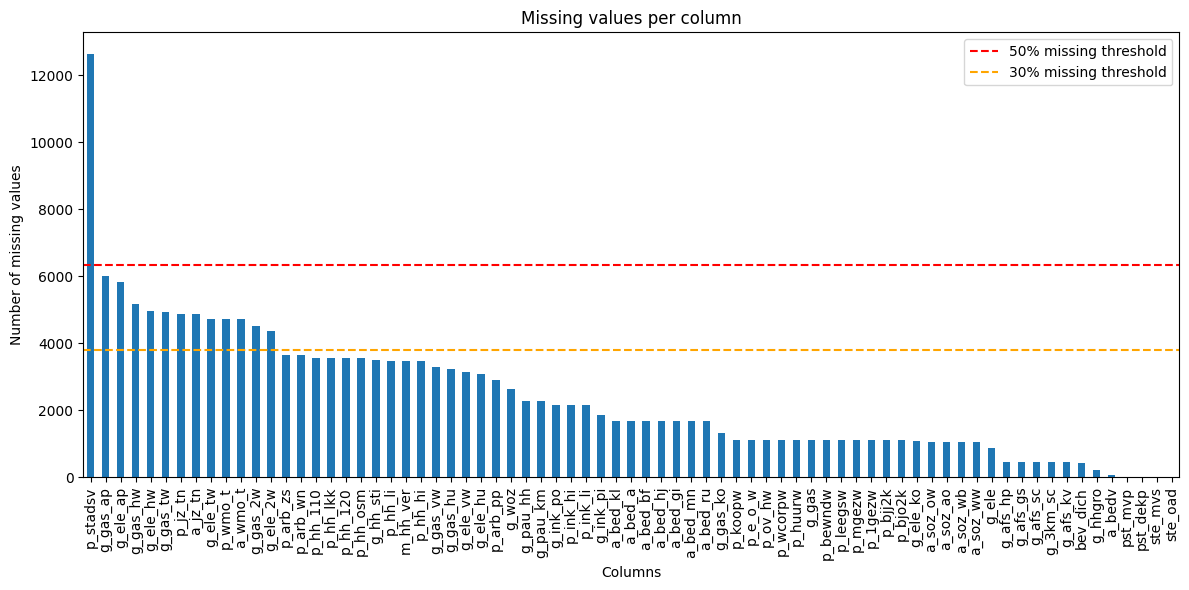

In [53]:
missing = df.isna().sum()
missing = missing[missing>0].sort_values(ascending=False)

total_rows = len(df)
missing_perc_50 = 0.5 * total_rows
missing_perc_30 = 0.3 * total_rows


plt.figure(figsize=(12,6))
missing.plot(kind='bar')
plt.axhline(missing_perc_50, color = 'red', linestyle = '--', label = '50% missing threshold')
plt.axhline(missing_perc_30, color = 'orange', linestyle = '--', label = '30% missing threshold')
plt.title("Missing values per column")
plt.ylabel("Number of missing values")
plt.xlabel("Columns")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
pipe = Pipeline([("scaler", StandardScaler()),("knn", KNNImputer(n_neighbors=5))])
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
df_num_cols = df[num_cols]
df_cat_cols = df[cat_cols]

df_num_cols_imputed = pipe.fit_transform(df_num_cols)
df_num_cols_imputed = pd.DataFrame(df_num_cols_imputed, columns = num_cols, index = df.index)
df = pd.concat([df_num_cols_imputed, df_cat_cols], axis =1)

In [43]:
missing_df = (
    df.isna()
      .sum()
      .reset_index()
      .rename(columns={'index': 'column', 0: 'missing_values'})
)

pd.set_option('display.max_rows', None)
missing_df


,column,missing_values
0,gwb_code_10,0
1,gwb_code_8,0
2,regio,0
3,gm_naam,0
4,recs,0
5,gwb_code,0
6,ind_wbi,0
7,a_inw,0
8,a_man,0
9,a_vrouw,0
